# GCN Model

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.metrics
from math import sqrt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from spektral.layers import GCNConv
import scipy.sparse as sp
import csv

2023-02-27 14:47:39.650644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 14:47:40.393871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 14:47:40.393896: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 14:47:42.231512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Load and PreProcess 

In [2]:
data = np.load('data/pems08.npz')
data = data.f.data
data.shape

(17856, 170, 3)

In [3]:
path = 'data/distance.csv'

In [4]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices):
    with open(distance_df_filename, 'r') as f:
        reader = csv.reader(f)
        header = f.__next__()
        edges = [(int(i[0]),int(i[1])) for i in reader]
    A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
    for i, j in edges:
            A[i, j] = 1
    return A

In [5]:
adj = get_adjacency_matrix(path, 170)

In [6]:
import tensorflow as tf
import scipy.sparse as sp
import numpy as np


def normalized_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    normalized_adj = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    normalized_adj = normalized_adj.astype(np.float32)
    return normalized_adj
    
def sparse_to_tuple(mx):
    mx = mx.tocoo()
    coords = np.vstack((mx.row, mx.col)).transpose()
    L = tf.SparseTensor(coords, mx.data, mx.shape)
    return tf.sparse.reorder(L) 
    
def calculate_laplacian(adj, lambda_max=1):  
    adj = normalized_adj(adj + sp.eye(adj.shape[0]))
    adj = sp.csr_matrix(adj)
    adj = adj.astype(np.float32)
    return sparse_to_tuple(adj)
    

In [7]:
tA = calculate_laplacian(adj)

2023-02-27 14:47:49.243032: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-27 14:47:49.243725: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-27 14:47:49.243800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rohullah-UX461UN): /proc/driver/nvidia/version does not exist
2023-02-27 14:47:49.247209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
type(tA)

tensorflow.python.framework.sparse_tensor.SparseTensor

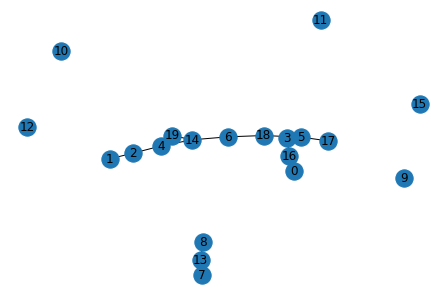

In [159]:
import networkx as nx 
addd = adj
addd= addd[:20,:20]
G = nx.from_numpy_array(np.array(np.array(addd)))
nx.draw(G, with_labels=True)
#plt.savefig("Graph.png")


In [160]:
import seaborn as sns
A = nx.adjacency_matrix(G)
AA = A.todense()
AA

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [161]:
def draw_coloring(G,coloring,colors):
    fig = plt.figure()
    n_colors = len(colors)

    pos = nx.spring_layout(G)
    for i in range(n_colors):
        nx.draw_networkx_nodes(G,pos,[x for x in G.nodes() if coloring[x]==i],node_color=colors[i])
    nx.draw_networkx_edges(G,pos,alpha=0.5)
    plt.axis('off')
    plt.show() 
    return fig

In [162]:
some_colors = ['red','blue','green','yellow','purple']

In [163]:
def random_coloring(graph,n_colors):
    coloring = {}
    for node in graph.nodes():
        coloring[node] = np.random.randint(0,n_colors)
    return coloring

In [164]:
some_coloring = random_coloring(G,5)

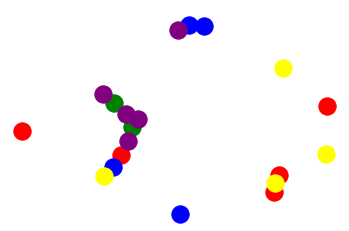

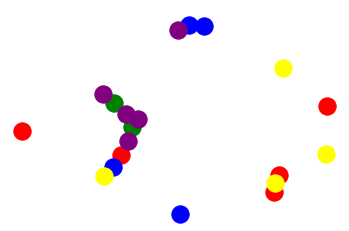

In [165]:
draw_coloring(G, some_coloring,some_colors)

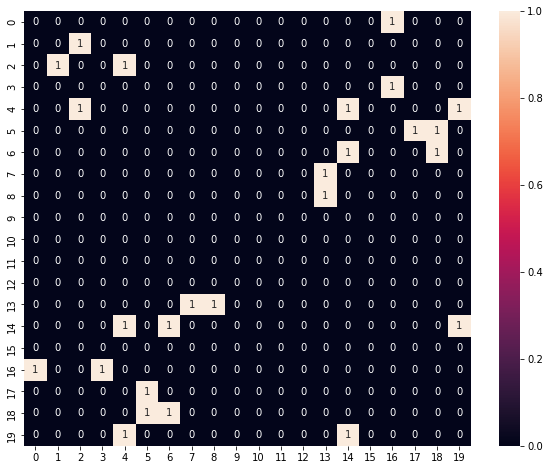

In [166]:
plt.figure(figsize=(10,8))
sns.heatmap(AA,annot=True)
#plt.savefig("adjeceny_matrix.png")
plt.show()

In [222]:
X = data[:,:,1]  # Feature matrix
A = adj  # Adjacency matrix
y = data[:,:,0]

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
trainX, trainA, trainY = X[:train_size], A[:train_size], y[:train_size]
testX, testA, testY = X[train_size:], A[train_size:], y[train_size:]

In [215]:
# Define the GCN model
X_in = Input(shape=(trainX.shape[0],))
A_in = Input(shape=(trainadj.shape[0], trainadj.shape[1]))
X_1 = GCNConv(64, activation='relu', kernel_regularizer=l2(5e-4))([X_in, A_in])
X_2 = GCNConv(32, activation='relu', kernel_regularizer=l2(5e-4))([X_1, A_in])
output = Dense(1, activation=None)(X_2)
model = Model(inputs=[X_in, A_in], outputs=output)

In [216]:
# Compile the model
optimizer = Adam(learning_rate=0.01)
loss_fn = MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss_fn)
# Train the model
history = model.fit([trainadj,trainX], trainY, batch_size=64, epochs=10, verbose=2)

ValueError: Dimensions 136 and 14284 are not compatible

In [ ]:

# Evaluate the model
test_loss = model.evaluate([testX, testA], testY)
print('Test loss:', test_loss)